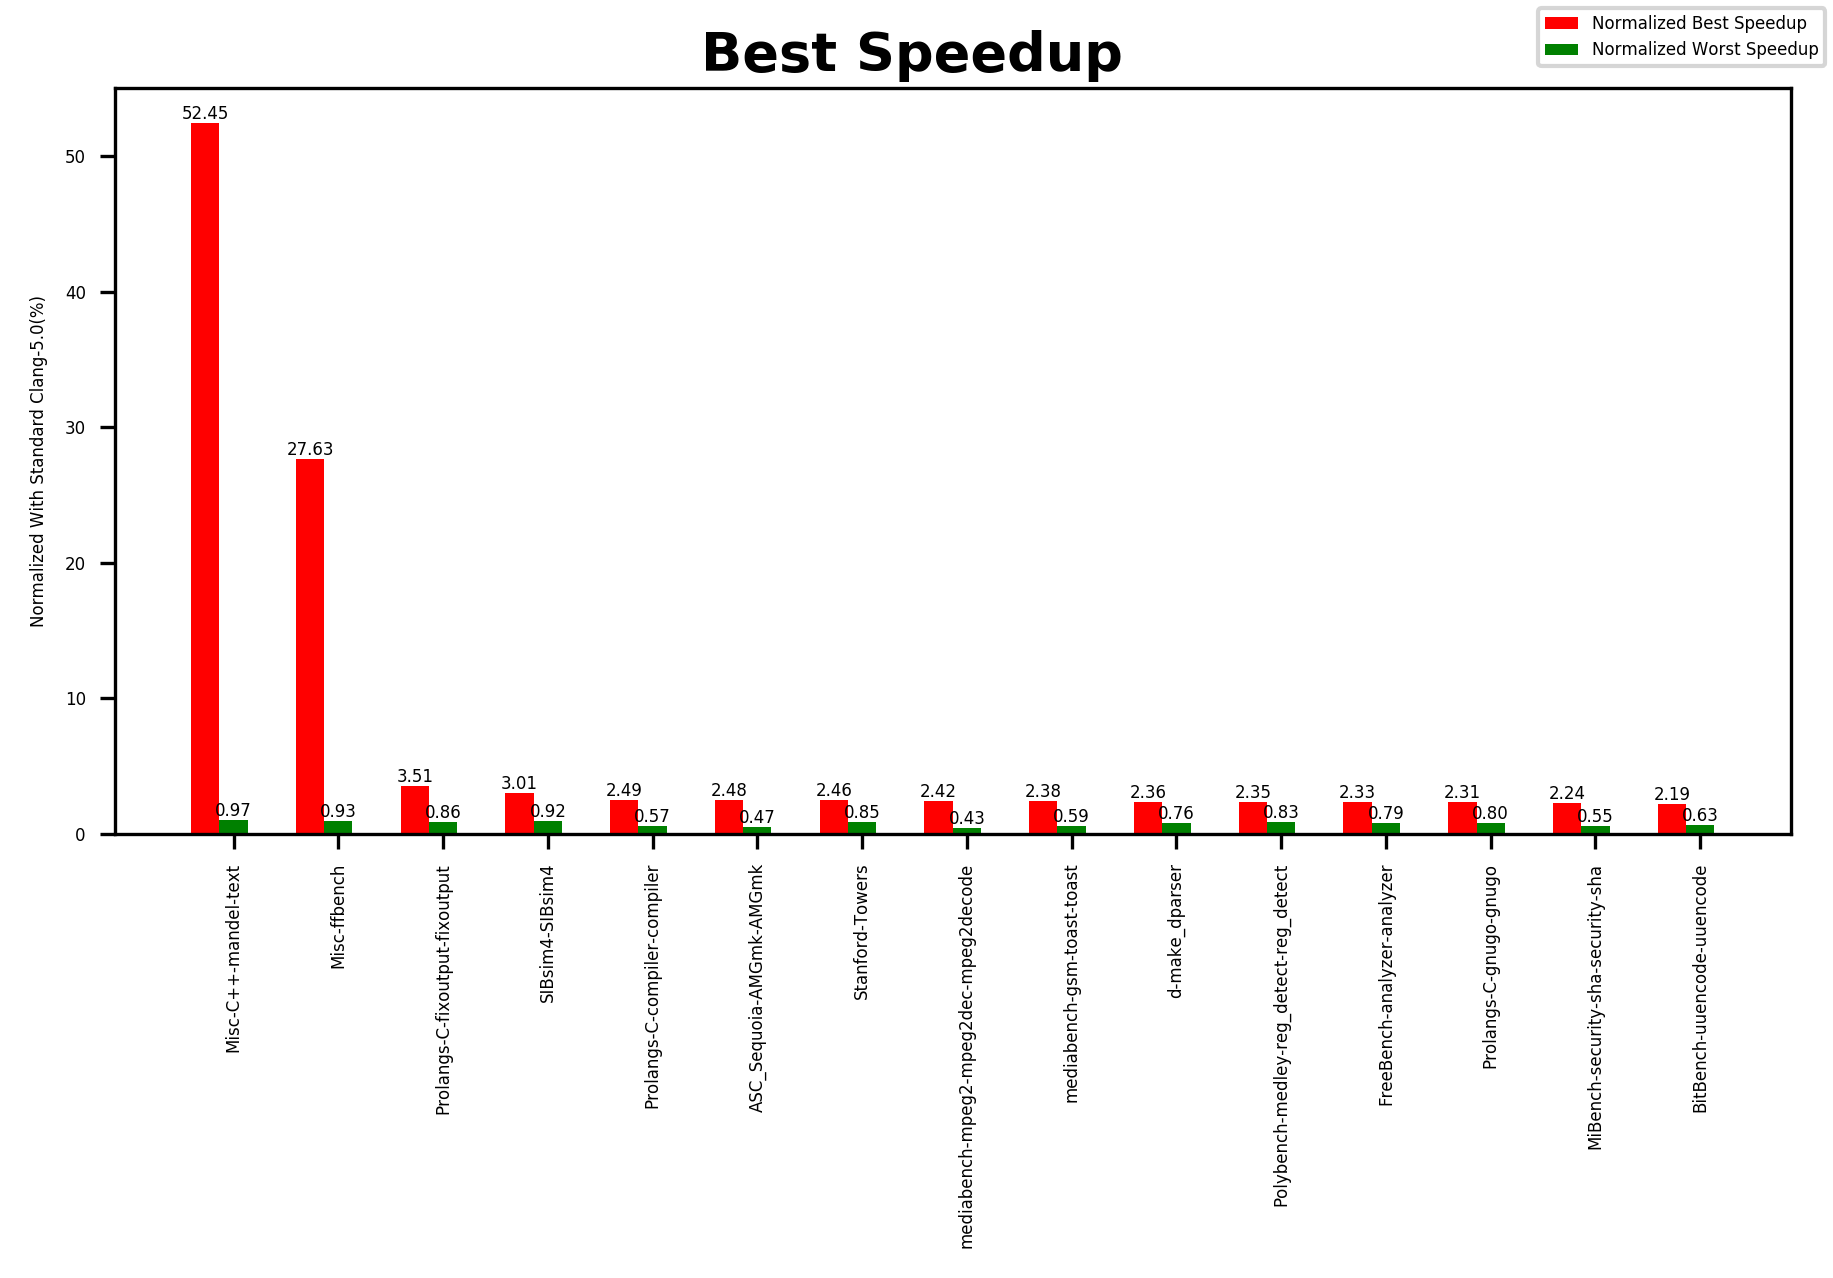

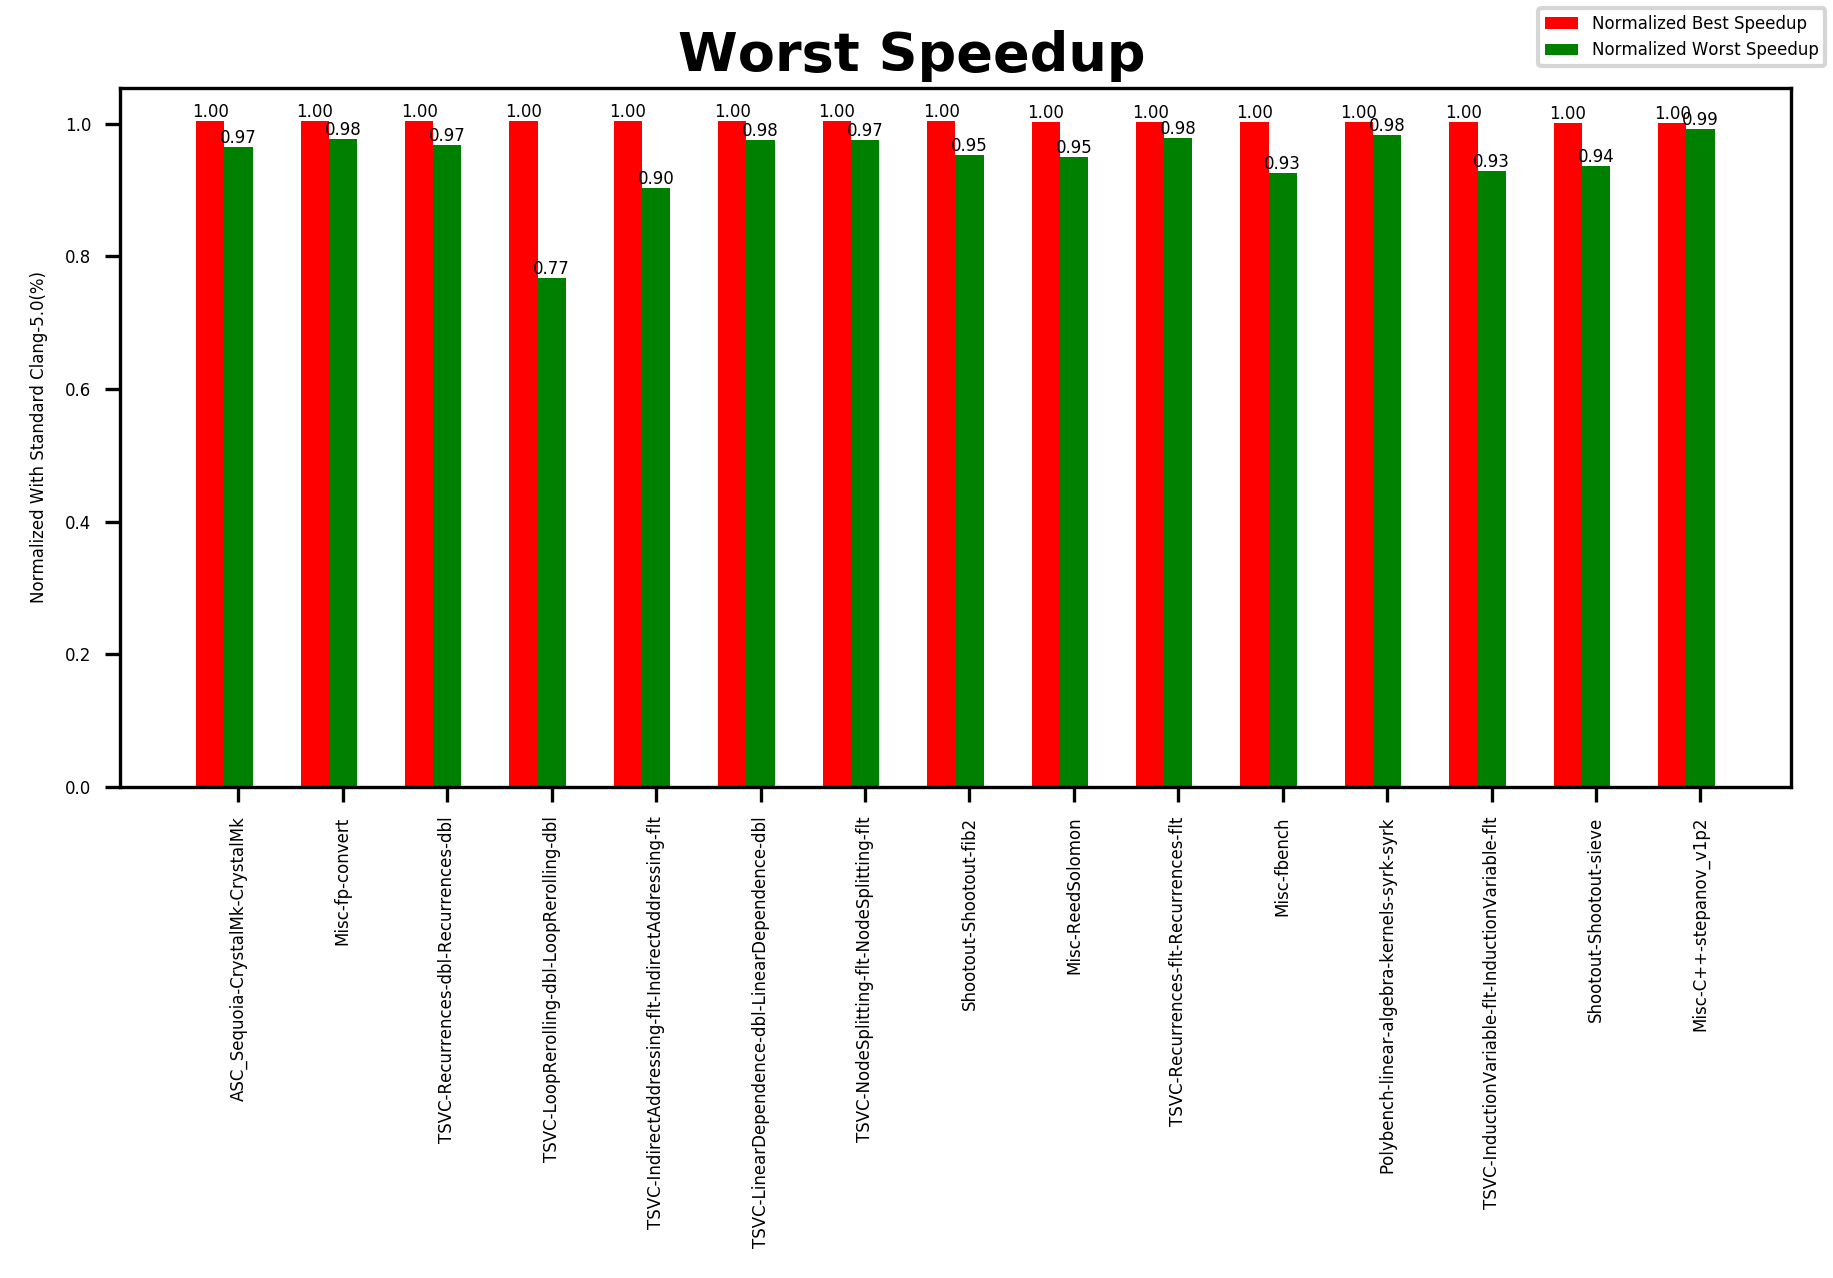

In [24]:
#!/usr/bin/python3
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

class FileCollector:
    def collect(self, InputPath):
        # Assume that only has one std file
        stdFile = ""
        randomFiles = []
        for root, dirs, files in os.walk(InputPath):
            for file in files:
                if file.endswith("_Time"):
                    randomFiles.append(root + '/' + file)
                if file.endswith("_STD"):
                    stdFile = root + '/' + file
                    
        return randomFiles, stdFile

class BenchmarkDictListsGen:
    
    """
    Return format:
    randomBenchmarks = {"name": [[time, "set"]]} , which the value is sorted by the time, 
                                                   the index lower is the faster.
    stdBenchmarks = [["name", time]]
    """
    def genFullInfo(self, randomFiles, stdFile):
        '''Get stdBenchmarks'''
        stdBenchmarks = []
        tmp = []
        with open(stdFile, "r") as file:
            # The set in stdFile is useless, and it is the left value in previous random run.
            # Therefore, we just ignore it.
            for line in file:
                tmp.append(line.strip().split(","))
            file.close()
        for benchmark in tmp:
            buf = []
            # ex. ['CoyoteBench-almabench', ' 29', ' 9.707262638999964']
            buf.append(benchmark[0]) # name
            buf.append(float(benchmark[2])) # time
            stdBenchmarks.append(buf)
                       
        '''Get randomBenchmarks'''
        # dict with benchmark name as keys
        randomBenchmarks = {b[0]: [] for b in stdBenchmarks}
        tmp = []
        for randomFile in randomFiles:
            with open(randomFile, "r") as file:
                for line in file:
                    tmp.append(line.strip().split(","))
                file.close()
        for benchmark in tmp:
            buf = []
            # ex. ['CoyoteBench-almabench', ' 29', ' 9.707262638999964']
            buf.append(float(benchmark[2])) # time
            buf.append(benchmark[1]) # set
            # use benchmark name as key
            try:
                randomBenchmarks[benchmark[0]].append(buf)
            except Exception as e:
                pass
                # ex. Benchmark name error: 'Prolangs-C-unix-tbl-unix-tbl'
                #print("Benchmark name error: {}\n".format(e))
        # Sort dict's value with its time incremently
        for dictKey, value in randomBenchmarks.items():
            randomBenchmarks[dictKey] = sorted(value, key = itemgetter(0))
        
        return randomBenchmarks, stdBenchmarks

    """
    No return.
    Record Format: (Name, BestSet, StdTime)
    """
    def genBestSet(self, randomBenchmarks, stdBenchmarks, Loc):
        with open(Loc, 'w') as file:
            for b in stdBenchmarks:
                Name = b[0]
                BestSet = randomBenchmarks[Name][0][1]
                StdTime = b[1]
                file.write("{}, {}, {}\n".format(Name, BestSet, StdTime))
            file.close()
    
    """
    Return format:
    normDescendingList = ["name", HeadInfo, TailInfo] , the lower index is the faster.
    HeadInfo = [StdTime/HeadRandTime, HeadRandSet, HeadRandTime, StdTime]
    TailInfo = [StdTime/TailRandTime, TailRandSet, TailRandTime, StdTime]
    """
    def genBestNormalizedList(self, randomBenchmarks, stdBenchmarks):
        '''
        gen best speedup lists
        '''
        normDescendingList = []
        normBenchmarksDict = {b[0]: [] for b in stdBenchmarks}
        for benchmark in stdBenchmarks:
            # Get the std time
            StdTime = benchmark[1]
            # Get the first/best from random results
            key = benchmark[0]
            HeadRandTime = randomBenchmarks[key][0][0]
            HeadRandSet = randomBenchmarks[key][0][1]
            TailRandTime = randomBenchmarks[key][-1][0]
            TailRandSet = randomBenchmarks[key][-1][1]
            #Add into dict
            HeadInfo = [StdTime/HeadRandTime, HeadRandSet, HeadRandTime, StdTime]
            TailInfo = [StdTime/TailRandTime, TailRandSet, TailRandTime, StdTime]
            normBenchmarksDict[key].append([HeadInfo, TailInfo])
        # Convert Dict into List
        for key, value in normBenchmarksDict.items():
            # value[0][0] is HeadInfo = [StdTime/HeadRandTime, HeadRandSet, HeadRandTime, StdTime]
            # value[0][1] is TailInfo = [StdTime/TailRandTime, TailRandSet, TailRandTime, StdTime]
            temp = [key, value[0][0], value[0][1]]
            normDescendingList.append(temp)
        # Sort the List based on the normalized speedup in descending order
        normDescendingList.sort(key = lambda x: x[1][0], reverse=True)
        
        return normDescendingList

class GraphDrawer:
    OutputLoc = "./output/"
    # Helper method
    def GraphGenerator_AutoLabel(self, rects, ax, location):
        horizontalAlign = 'center'
        if location == "up":
            verticalAlign='bottom'
        else:
            verticalAlign='top'

        for rect in rects:
            h = rect.get_height()
            if location == "up":
                h = h * 1.0
            else:
                h = h * 1.05
            label = "%.2f" % (h)
            ax.text(rect.get_x()+rect.get_width()/2., h, label,
                    ha=horizontalAlign, va=verticalAlign)

    """
    Input Format:
    InputLists = [["name", value_1 for bar_1, value_2 for bar_2]]
    you can leverage self.dataFormatter()
    """
    def draw(self, InputLists, Title):
        '''Split input into 3 lists for graph'''
        list_1 = []
        list_2 = []
        benchmarkName = []
        for data in InputLists:
            benchmarkName.append(data[0])
            list_1.append(data[1])
            list_2.append(data[2])
        '''Draw'''
        plt.rc('font', size=4)
        fig = plt.figure(dpi=300)
        width = 0.27 # the width of the barspass
        ax = fig.add_subplot(111)
        index = np.arange(len(InputLists))
        rects1 = ax.bar(index, list_1, width, color='r')
        rects2 = ax.bar(index + width, list_2, width, color='g')
        ax.set_ylabel('Normalized With Standard Clang-5.0(%)')
        fig.suptitle(Title, fontweight='bold', fontsize=13, y=1.03)
        plt.tight_layout()
        ax.set_xticks(index + width)
        ax.set_xticklabels(benchmarkName)
        fig.legend( (rects1[0], rects2[0]), ('Normalized Best Speedup', 'Normalized Worst Speedup') )
        self.GraphGenerator_AutoLabel(rects1, ax, "up")
        #self.GraphGenerator_AutoLabel(rects2, ax, "down")
        self.GraphGenerator_AutoLabel(rects2, ax, "up")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
        fig.savefig(self.OutputLoc + Title + ".png", dpi=fig.dpi, bbox_inches='tight')
    
    """
    Input Format:
    InputLists: See return format from:BenchmarkDictListsGen.genBestNormalizedList()
    
    Return Format: ret = [["name", value_1 for bar_1, value_2 for bar_2]]
    """
    def dataFormatter(self, InputLists):
        ret = []
        for data in InputLists:
            tmp = []
            tmp.append(data[0])
            tmp.append(data[1][0]) # speedup
            tmp.append(data[2][0]) # slow down
            ret.append(tmp)
            
        return ret
        
        
if __name__ == '__main__':
    # Get input files
    Input = FileCollector()
    randomFiles, stdFile = Input.collect("./input")
    benchmarks = BenchmarkDictListsGen()
    # Get full info about the benchmarks
    randomBenchmarks, stdBenchmarks = benchmarks.genFullInfo(randomFiles, stdFile)
    # Record the best set and its time
    benchmarks.genBestSet(randomBenchmarks, stdBenchmarks, "./output/BestRecord")
    # Get the best and worst info about the benchmarks
    normDescendingList = benchmarks.genBestNormalizedList(randomBenchmarks, stdBenchmarks)
    # Get the 5% values about the best and worst
    FivePercentLen = int(len(normDescendingList)*0.05)
    BestSpeedupList = normDescendingList[:FivePercentLen]
    WorstSpeedupList = normDescendingList[-FivePercentLen:]
    # Draw graph
    drawer = GraphDrawer()
    DrawInput = drawer.dataFormatter(BestSpeedupList)
    drawer.draw(DrawInput, "Best Speedup")
    DrawInput = drawer.dataFormatter(WorstSpeedupList)
    drawer.draw(DrawInput, "Worst Speedup")
    

